# Case study visualizations development

In [36]:
# imports
import boto3
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import os
from shapely.geometry import Point
import sys  # Used for progress bar
from case_study_eval_utils import *
import datetime
import sys
import os
from io import BytesIO
plt.style.use("tableau-colorblind10")

# Import qaqc stage plot functions
sys.path.append(os.path.abspath("../scripts/3_qaqc_data"))
from qaqc_plot import flagged_timeseries_plot, _plot_format_helper, id_flag


# Set AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client("s3")  # for lower-level processes

# Set relative paths to other folders and objects in repository.
BUCKET_NAME = "wecc-historical-wx"
QAQC_DIR = "3_qaqc_wx"
MERGE_DIR = "4_merge_wx"
stations_csv_path = f"s3://{BUCKET_NAME}/{QAQC_DIR}/all_network_stationlist_qaqc.csv"

## Step 1: Filter stations for event time and location

In [12]:
# set up event start and end dates, and affected counties
event_start_date = "2007-10-05"
event_end_date = "2007-11-30"
event_counties = ['San Diego','Los Angeles','Ventura','Santa Barbara','San Bernardino','Orange','Riverside']

In [13]:
# read in merge station list
stn_list = pd.read_csv(
    "s3://wecc-historical-wx/4_merge_wx/all_network_stationlist_merge.csv"
)

In [14]:
# convert it into geodataframe
stns_gdf = gpd.GeoDataFrame(
    stn_list,
    geometry=gpd.points_from_xy(
        stn_list.longitude, stn_list.latitude, crs="EPSG:4326"
    ),
)

In [15]:
# read in  CA county boundaries shapefile
ca_counties = gpd.read_file(
    "s3://wecc-historical-wx/0_maps/ca_counties/CA_Counties.shp"
)
ca_counties = ca_counties.to_crs(stns_gdf.crs)  # Convert to station CRS

In [16]:
# define the event geometry - we'll focus on one county for now (San Diego - where the largest fires occurred)
event_geom = ca_counties[ca_counties["NAME"] == ("San Diego")]  # .isin(event_counties)]

In [17]:
# filter down to stations that are in the target county
stns_gdf["intersects"] = stns_gdf.intersects(
    event_geom.unary_union
)  # See which stations intersect with the event polygon

event_stns = stns_gdf[stns_gdf["intersects"] == True].reset_index(
    drop=True
)  # Get just those stations, drop the others

In [18]:
# ...AND with start and end date within the event timeframe
event_stns = event_stns[
    (event_stns["start-date"] < event_end_date)
    & (event_stns["end-date"] > event_start_date)
]

## Step 2: Visualization

In [19]:
['104D97','b5302b','e77431','503431','55a393']
['104D97','ED254E','F9DC5C','71FFE4','A09BE7']
test = ['1C3C6E','104D97','b5302b','e77431','503431','8DE3CF','A7D5B6']

In [21]:
cmap = cm.get_cmap("Dark2", 10)
#cmap = ["104D97", "b5302b", "e77431", "503431", "55a393"]

In [46]:
cmap = cm.get_cmap("tableau-colorblind10", 10)

ValueError: 'tableau-colorblind10' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

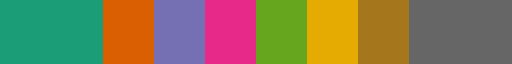

In [22]:
cmap

In [44]:
def event_plot_multiple_stations(
    sample: list,
    var: str,
    event: str,
    alt_start_date: str | None = None,
    alt_end_date: str | None = None,
    save_to_aws: str | None = None,
    save_local: str | None = None
):
    """
    Produces timeseries of variables along with any QAQC flags placed

    Parameters
    ----------
    sample : list
        subset of station list to generate plots for 
    var : str
        name of variable
    event : str
        name of case study event
    alt_start_date : str
        date of different event, must be in format "YYYY-MM-DD"
    alt_end_date : str
        date of different event, must be in format "YYYY-MM-DD"
    save_to_AWS: str
        if True, save figure to AWS 
        if False, do not save figure to AWS
    save_local: str
        if True, save figure to local repository
        if False, do not save figure to local repository
    Returns
    -------
    None
    """

    fig, ax = plt.subplots(figsize=(10, 3))
    sample = sample.reset_index()

    # Loop through station in sample
    for i in sample.index:
        # get the station ID and network name
        station = sample.loc[i,"era-id"]
        network = sample.loc[i,"network"]

        # load station datate
        url = f"s3://{BUCKET_NAME}/{MERGE_DIR}/{network}/{station}.zarr"
        ds = xr.open_zarr(url)
        df = ds.to_dataframe()
        df = df.reset_index()

        # subset data to 14 days before and after the event window
        # ! this needs to be programmatized, currently hard coded for santa ana winds
        mask = (df["time"] >= "2007-10-05") & (df["time"] <= "2007-11-30")
        df = df.loc[mask]
        if var in df.columns:
            df.plot(
                ax=ax,
                x="time",
                y=var,
                marker=" ",
                ms=4,
                lw=1,
                #color = custom_cmap(i),
                alpha=0.5,
                label=station,
            )

            # plot any flags placed by QA/QC
            if len(df[var + "_eraqc"].dropna().unique()) != 0:
                # identify flagged data, can handle multiple flags
                for flag in df[var + "_eraqc"].dropna().unique():
                    flag_name = id_flag(flag)
                    flag_str = 100 * len(df.loc[df[var + "_eraqc"] == flag, var]) / len(df)
                    flag_label = f"{flag_str:.3f}% of data flagged by {flag_name}"

                    flagged_data = df[~df[var + "_eraqc"].isna()]
                    flagged_data.plot(
                        x="time",
                        y=var,
                        ax=ax,
                        marker="o",
                        ms=7,
                        lw=0,
                        mfc="none",
                        color = 'C3',
                        label=flag_label,
                    )

    # plot event timeline
    event_start, event_end = event_info(event, alt_start_date, alt_end_date)
    ax.axvspan(
        event_start,
        event_end,
        color = 'black',
        alpha=0.05,
        label="{}".format(event),
    )
    legend = ax.legend(loc="upper left", prop={"size": 7})
    leg_lines = legend.get_lines()
    plt.setp(leg_lines, linewidth=2)

    # plot aesthetics
    ylab, units, miny, maxy = _plot_format_helper(var)
    plt.ylabel(f"{ylab} [{units}]")
    plt.xlabel("")
    stn = df["station"].unique()[0]
    plt.title(
        f"QA/QC event evaluation: {event}",
        fontsize=10,
    )

    # Set name of saved figure
    figname = f"case_study_multi_station_test.png"

    # save to AWS
    if save_to_aws:

        s3 = boto3.resource("s3")
        bucket_name = "wecc-historical-wx"

        img_data = BytesIO()
        plt.savefig(img_data, format="png", bbox_inches="tight")
        img_data.seek(0)

        bucket = s3.Bucket(bucket_name)
        bucket.put_object(
            Body=img_data, ContentType="image/png", Key=f"4_merge_wx/{figname}"
        )

    # save to local
    if save_local:
        plt.savefig(f"../figures/{figname}", dpi=300)

    return None

In [23]:
# take a sub sample of stations
sub_sample = find_other_events(
    event_stns, event_start_date, event_end_date, 14, 5, return_stn_ids=True
)

Subsetting station record for event duration with 14 day buffer...
5 stations selected for evaluation for comparison!
Stations selected for evaluation:
 ['RAWS_OGVC1', 'RAWS_LSFC1', 'ASOSAWOS_72290753143', 'CWOP_AS316', 'CIMIS_153']


In [ ]:
event_plot_multiple_stations(sub_sample, 'sfcWind', 'santa_ana_wind')

### Plotting stations that register an event signal

stations that register the event:
- CWOP_AS488
- SGXWFO_SDUSS
- CWOP_C5252
- ASOSAWOS_72290403178
- RAWS_POTC1


In [42]:
signal_list = stn_list[stn_list["era-id"].isin(
    ["CWOP_AS488", "SGXWFO_SDUSS", "CWOP_C5252"]#, "ASOSAWOS_72290403178", "RAWS_POTC1"]
)]

''	Cerulean/Blue
''	Pumpkin/Orange
'ABABAB'	Dark Gray/Gray
'595959'	Mortar/Grey
''	Picton Blue/Blue
''	Tenne (Tawny)/Orange
'898989'	Suva Grey/Grey
''	Sail/Blue
''	Macaroni And Cheese/Orange
'CFCFCF'	Very Light Grey/Grey

In [47]:
# Define a list of colors
custom_colors1 = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]
custom_colors2 = ["#104D97", "#b5302b", "#e77431", "#503431", "#55a393"]
custom_colors3 = ["#104D97", "#ED254E", "#F9DC5C", "#71FFE4", "#A09BE7"]
custom_colors4 = ["#104D97", "#b5302b", "#e77431", "#503431", "#8DE3CF"]
custom_colors5 = ["#104D97", "#b5302b", "#A09BE7", "#503431", "#8DE3CF"]
colorblind10 = [
    "#006BA4",
    "#FF800E",
    "#5F9ED1",
    "#C85200",
    "#A2C8EC",
    "#FFBC79",
    "#A2C8EC",
]

# "#1C3C6E",
# "#A7D5B6",

In [48]:
# Create a ListedColormap
custom_cmap = ListedColormap(colorblind10)

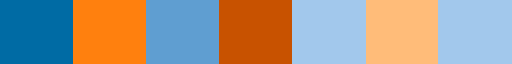

In [49]:
custom_cmap

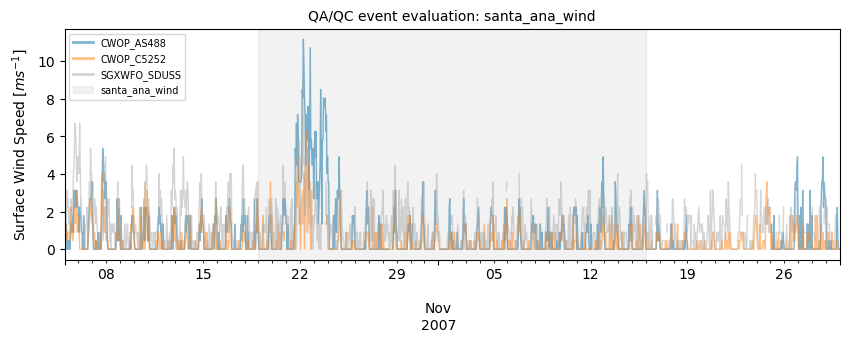

In [50]:
event_plot_multiple_stations(signal_list, "sfcWind", "santa_ana_wind")

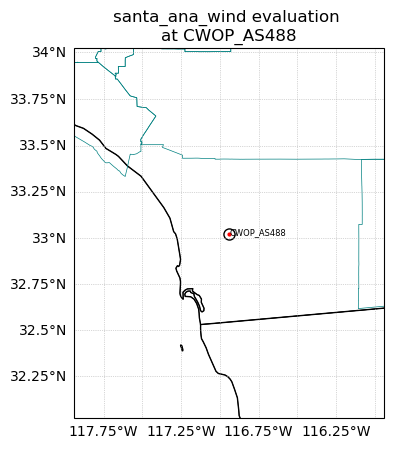

In [ ]:
# peak at where individual stations of interest are located
stn_visualize('CWOP_AS488', stn_list, 'santa_ana_wind')

In [ ]:
def stn_visualize(stn_list, event_to_eval):
    """
    Produces simple map of station relevant to event boundary.

    Parameters
    ----------
    stn_list : pd.DataFrame
        stationlist
    event_to_eval : str
        name of case study event

    Returns
    -------
    None
    """

    stn_list = stn_list.reset_index()

    lat_lon_list = []

    for i in stn_list:
        # grab station id info and reproject coords
        stn = stn_list.iloc[[0]]
        lon, lat = stn.longitude.values[0], stn.latitude.values[0]
        x, y = latlon_to_mercator_cartopy(lat, lon)
        lat

    # figure set-up
    fig, ax = plt.subplots(subplot_kw={"projection": ccrs.epsg(3857)})
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.STATES, lw=0.5)

    ax.set_extent([lon + 1, lon - 1, lat - 1, lat + 1])

    # Obtain the limits of the plot
    x0, x1, y0, y1 = ax.get_extent()

    # Create a polygon with the limits of the plot
    polygon = Polygon(((x0, y0), (x0, y1), (x1, y1), (x1, y0)))

    # Use only the counties that overlap with the actual plot
    ca_county = gpd.read_file(CENSUS_SHP)
    counties = ca_county[ca_county.overlaps(polygon)]

    # Plot the counties' geometries
    for geometry in counties.geometry:
        ax.add_geometries(
            geometry.boundary,
            crs=ax.projection,
            facecolor="none",
            edgecolor="teal",
            lw=0.5,
        )

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax.plot(lon, lat, "ok", markersize=8, transform=ccrs.PlateCarree(), mfc="none")
    ax.plot(x, y, ".r", markersize=4)
    ax.annotate(f"{stn_id}", xy=(x, y), xytext=(x + 10, y + 10), fontsize=6)
    # station name
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=["bottom", "left"], ls=":", lw=0.5
    )
    ax.set_title(f"{event_to_eval} evaluation \nat {stn_id}")

    return None

In [82]:
sub_sample.iloc[[0]]

,Unnamed: 0,era-id,latitude,longitude,elevation,start-date,end-date,pulled,time_checked,network,...,sfcwind_nobs,sfcwind_dir_nobs,rsds_nobs,total_nobs,qaqc,time_qaqc,merged,time_merge,geometry,intersects
241,6417,CWOP_AS488,33.02133,-116.94017,1540.0,2006-12-06 00:00:00+00:00,2022-01-07 06:07:00+00:00,Y,2023-04-06 18:02:34+00:00,CWOP,...,707690,519665,43,707712,Y,2025-05-02 09:51:09+00:00,Y,2025-06-12 19:27:53+00:00,POINT (-116.94017 33.02133),True
